# Figures

## SODA

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [33]:
clim = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/clim_ds.zarr'))
anom = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/anom_ds.zarr'))

In [3]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms#.load()

<xarray.Dataset>
Dimensions:         (time: 985, sigma2_bin: 99)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(493, 50), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(493, 50), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>

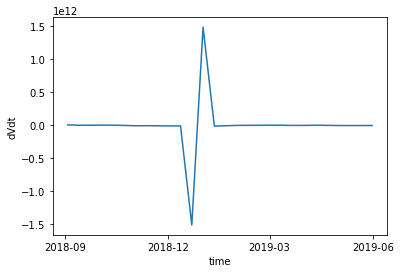

In [4]:
wmt_budget_terms.sel(time=slice('2018-09', '2019-05')).dVdt.sum('sigma2_bin').plot()

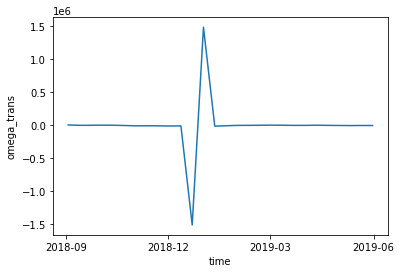

In [5]:
wmt_budget_terms.sel(time=slice('2018-09', '2019-05')).omega_trans.sum('sigma2_bin').plot()

In [6]:
#Converting time from Julian to datetime64[ns] object
datetimeindex = wmt_budget_terms.indexes['time'].to_datetimeindex()
wmt_budget_terms['time'] = datetimeindex

/tmp/ipykernel_439/1886496733.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = wmt_budget_terms.indexes['time'].to_datetimeindex()


In [7]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (time: 985, sigma2_bin: 99)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time            (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T...
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(493, 50), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(493, 50), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float32 dask.array<chunksize=(493, 99), meta=np.ndarray>

## Time mean budgets

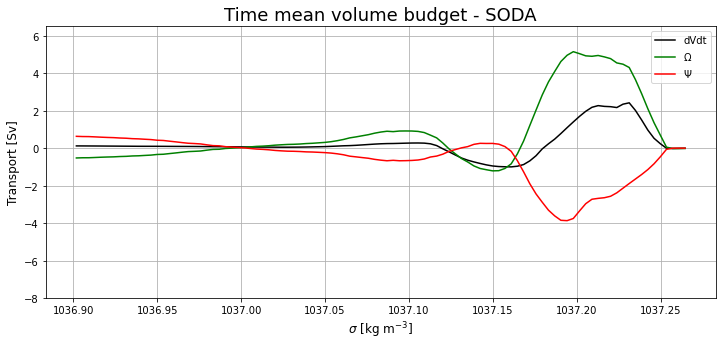

In [9]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.ylim(-8,6.5)
#plt.xlim(1037.15, 1037.27)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18);

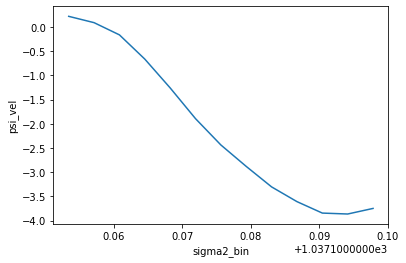

In [10]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.15, 1037.2)).plot()

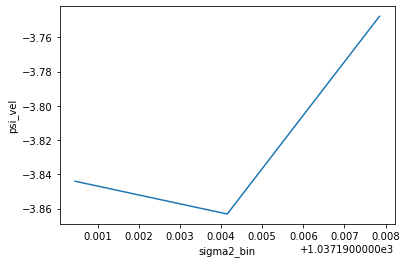

In [15]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.19, 1037.2)).plot()

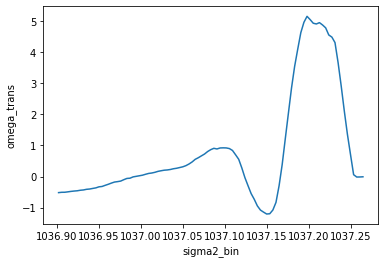

In [12]:
wmt_budget_terms.omega_trans.mean('time').plot()

### $\frac{\partial V}{\partial t}$

In [16]:
#bottom
dVdt_bot = (wmt_budget_terms.dVdt.mean('time')[-1] - 
             wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.194, method='nearest'))/1e6
dVdt_bot.load()

<xarray.DataArray 'dVdt' ()>
array(-1.10170342)

In [17]:
#deep
dVdt_deep = (wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.194, method='nearest') - 
              wmt_budget_terms.dVdt.mean('time')[0])/1e6
dVdt_deep.load()

<xarray.DataArray 'dVdt' ()>
array(0.97294167)

In [19]:
dVdt_bot + dVdt_deep

<xarray.DataArray 'dVdt' ()>
array(-0.12876175)

### $\Psi$

In [21]:
psi_bot = (wmt_budget_terms.psi_vel.mean('time')[-1] - 
           wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.194, method='nearest'))
psi_bot.load()

<xarray.DataArray 'psi_vel' ()>
array(3.8680186, dtype=float32)

In [22]:
psi_deep = (wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.194, method='nearest') - 
            wmt_budget_terms.psi_vel.mean('time')[0])
psi_deep.load()

<xarray.DataArray 'psi_vel' ()>
array(-4.498981, dtype=float32)

In [23]:
psi_bot + psi_deep 

<xarray.DataArray 'psi_vel' ()>
array(-0.6309624, dtype=float32)

### $\Omega$

In [26]:
#bottom
omega_bot = (wmt_budget_terms.omega_trans.mean('time')[-1] - 
             wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=1037.194, method='nearest'))
omega_bot.load()

<xarray.DataArray 'omega_trans' ()>
array(-4.96920425)

In [27]:
#deep
omega_deep = (wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=1037.194, method='nearest') - 
              wmt_budget_terms.omega_trans.mean('time')[0])
omega_deep.load()

<xarray.DataArray 'omega_trans' ()>
array(5.47831669)

In [28]:
omega_bot + omega_deep

<xarray.DataArray 'omega_trans' ()>
array(0.50911244)

### Budget

In [30]:
dVdt_bot

<xarray.DataArray 'dVdt' ()>
array(-1.10170342)

In [31]:
psi_bot + omega_bot

<xarray.DataArray ()>
array(-1.10118563)

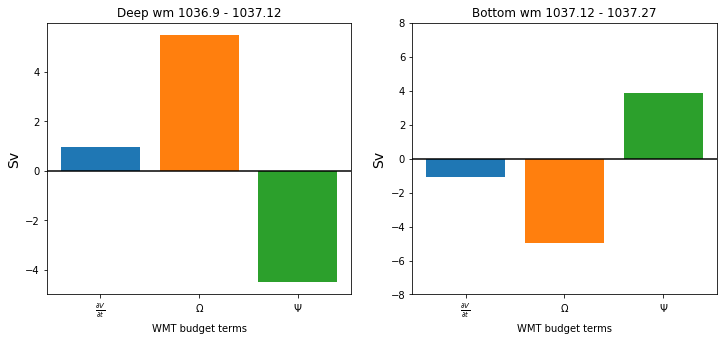

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_deep)
ax0.bar(x=r'$\Omega$', height = omega_deep)
ax0.bar(x=r'$\Psi$', height=psi_deep)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1036.9 - 1037.194')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_bot)
ax1.bar(x=r'$\Omega$', height = omega_bot)
ax1.bar(x=r'$\Psi$', height=psi_bot)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.194 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')

plt.ylim(-8,8);

## Monthly Climatology

In [34]:
clim

<xarray.Dataset>
Dimensions:      (month: 12, sigma2_bin: 99)
Coordinates:
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * sigma2_bin   (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables:
    dVdt         (month, sigma2_bin) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    omega_trans  (month, sigma2_bin) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    psi_vel      (month, sigma2_bin) float32 dask.array<chunksize=(1, 99), meta=np.ndarray>

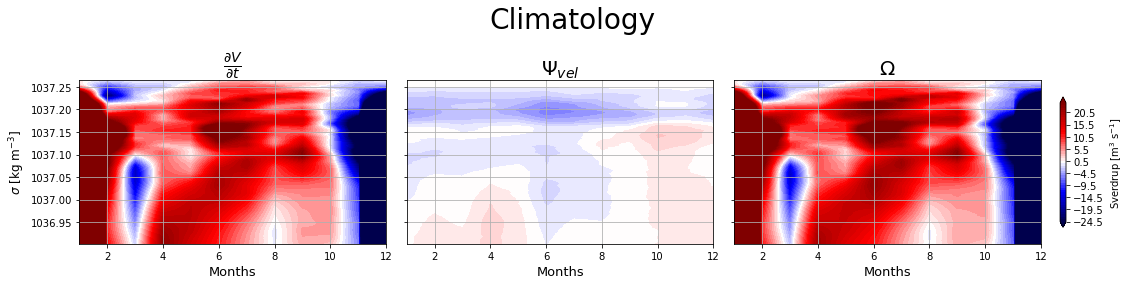

In [37]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim.dVdt
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_xlabel('Months', fontsize=13)
#ax0.set_ylim(1037.3, 1035.5)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim.psi_vel
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_xlabel('Months', fontsize=13)
#ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim.omega_trans
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_xlabel('Months', fontsize=13)
#ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [38]:
dVdt_clim_deep = clim.dVdt.sel(sigma2_bin=1037.194, method='nearest') - clim.dVdt.isel(sigma2_bin=0)
dVdt_clim_deep.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-99.08633431,  -5.96899782,  15.27553844, -16.55761585,
        -0.5211126 ,   9.13496082,   6.77674461,   7.29499024,
         9.47494872,  -9.44912714, -11.18778005, 108.05142204])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [39]:
dVdt_clim_bot = clim.dVdt.isel(sigma2_bin=-1) - clim.dVdt.sel(sigma2_bin=1037.194, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-95.39190845,  -8.68311479, -13.51345934,  -7.27221171,
       -16.01707793, -19.30683658,  -8.67652011,  -5.71055696,
       -12.30103229,   5.89425256,  15.43237131, 154.69115888])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

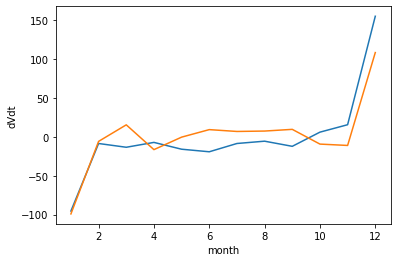

In [40]:
dVdt_clim_bot.plot()
dVdt_clim_deep.plot();

### $\Psi$

In [41]:
psi_clim_deep = clim.psi_vel.sel(sigma2_bin=1037.194, method='nearest') - clim.psi_vel.isel(sigma2_bin=0)
psi_clim_deep.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-5.1636147, -4.838806 , -3.7024717, -4.9839087, -5.4271545,
       -5.345288 , -5.6958766, -4.5238748, -3.7687924, -2.7574115,
       -3.3981376, -4.344367 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [42]:
psi_clim_bot = clim.psi_vel.isel(sigma2_bin=-1) - clim.psi_vel.sel(sigma2_bin=1037.194, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([4.877421 , 3.7476006, 2.8310783, 3.1386306, 4.4763813, 5.925834 ,
       5.5161104, 4.6548247, 3.8967426, 2.1329086, 1.9620421, 3.1659348],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

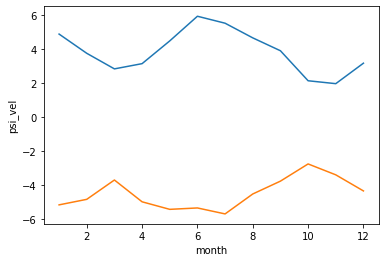

In [43]:
psi_clim_bot.plot()
psi_clim_deep.plot();

### $\Omega$

In [45]:
omega_clim_deep = clim.omega_trans.sel(sigma2_bin=1037.194, method='nearest') - clim.omega_trans.isel(sigma2_bin=0)
omega_clim_deep.load()

<xarray.DataArray 'omega_trans' (month: 12)>
array([-93.83988656,  -1.13019126,  18.97801004, -11.57370768,
         4.90604185,  14.48024953,  12.4726209 ,  11.81886505,
        13.24374111,  -6.69171528,  -7.78964231, 112.39578979])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [46]:
omega_clim_bot = clim.omega_trans.isel(sigma2_bin=-1) - clim.omega_trans.sel(sigma2_bin=1037.194, method='nearest')
omega_clim_bot.load()

<xarray.DataArray 'omega_trans' (month: 12)>
array([-100.27531548,  -12.43071547,  -16.34453752,  -10.41084232,
        -20.49345931,  -25.23267144,  -14.19263008,  -10.36538195,
        -16.19777458,    3.76134385,   13.47032902,  151.52522366])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

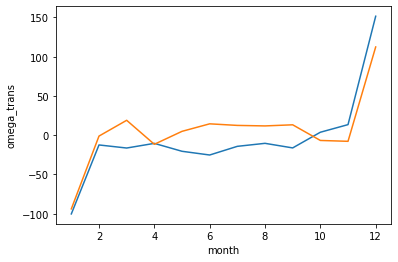

In [47]:
omega_clim_bot.plot()
omega_clim_deep.plot();

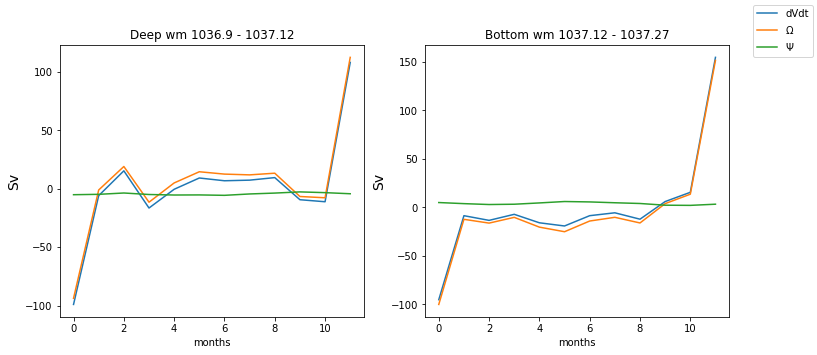

In [48]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_clim_deep, label='dVdt')
ax0.plot(omega_clim_deep, label=r'$\Omega$')
ax0.plot(psi_clim_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_clim_bot)#, label='dVdt')
ax1.plot(omega_clim_bot)#, label=r'$\Omega$')
ax1.plot(psi_clim_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## Anomaly

In [49]:
anom

<xarray.Dataset>
Dimensions:      (time: 985, sigma2_bin: 99)
Coordinates:
  * sigma2_bin   (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time         (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:...
Data variables:
    dVdt         (time, sigma2_bin) float64 dask.array<chunksize=(985, 99), meta=np.ndarray>
    omega_trans  (time, sigma2_bin) float64 dask.array<chunksize=(985, 99), meta=np.ndarray>
    psi_vel      (time, sigma2_bin) float64 dask.array<chunksize=(985, 99), meta=np.ndarray>

In [50]:
year_start_index = [0, 36, 73, 109, 146, 182, 219, 255, 292, 329, 
                    365, 402, 438, 475, 511, 548, 584, 621, 657, 
                    694, 730, 767, 803, 840, 876, 913, 949]

In [51]:
import warnings
warnings.filterwarnings("ignore")

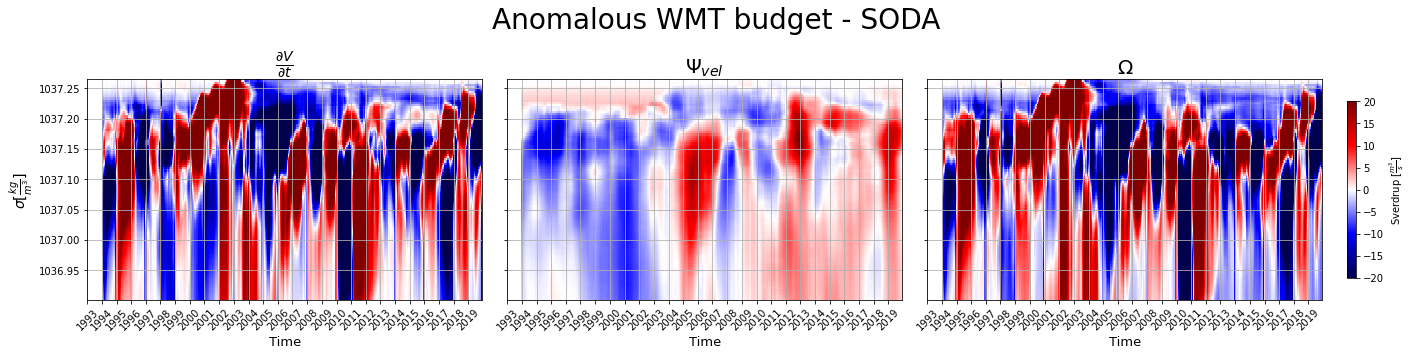

In [54]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

#ax00 = ax0.twinx()
#ax10 = ax1.twinx()
#ax20 = ax2.twinx()

dVdt_anom_rolled = anom.dVdt
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax0.set_ylim(1037.3, 1036.5)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(ax0.get_xticks(), rotation = 45)
ax0.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax0.set_xlabel('Time', fontsize=13)
#ax00.plot(sam.time.isel(index=slice(49, 54)), sam.ANN.isel(index=slice(49, 54)))
#ax00.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax0.grid()

psi_vel_anom_rolled = anom.psi_vel
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
#ax1.set_ylim(1037.3, 1036.5)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax1.set_xlabel('Time', fontsize=13)
#ax10.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax1.grid()

omega_anom_rolled = anom.omega_trans
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
#ax2.set_ylim(1037.3, 1036.5)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax2.set_xlabel('Time', fontsize=13)
#ax20.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax2.grid()

plt.suptitle('Anomalous WMT budget - SODA', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [55]:
dVdt_anom_deep = anom.dVdt.sel(sigma2_bin=1037.194, method='nearest') - anom.dVdt.isel(sigma2_bin=0)
dVdt_anom_deep.load()

<xarray.DataArray 'dVdt' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -1.13084740e+01, -9.93040932e+00, -7.30498789e+00, -3.83360132e+00,
       -3.82973878e-01,  3.38049365e+00,  6.80289760e+00,  8.55396474e+00,
        8.75983212e+00,  7.88969877e+00,  7.11460930e+00,  6.35075467e+00,
        5.50351501e+00,  5.17675244e+00,  4.72466984e+00,  4.61400236e+00,
        4.36744567e+00,  3.62747813e+00,  2.51294463e+00,  1.84958790e+00,
        9.22849422e-01,  1.91450770e-01, -5.73844426e-01, -1.47657057e+00,
       -2.00103737e+00, -2.81267009e+00, -3.59177357e+00, -4.33186204e+00,
       -2.29053155e+00, -1.82103493e-01,  1.05956163e+00,  2.16277982e+00,
        1.93424068e+00,  4.65262910e+00,  4.54554056e+00,  4.68162821e+00,
       -1.03774453e+00, -2.41133681e+00, -4.78374865e+00, -4.96129789e+00,
       -7.02136754e+00, -8.63845485e+00, -8.60285200e+00, -8.22293217e+00,
...
        5.03828016e+01,  5.18686288e+01,  5.06469117e+01,  5.02107329e+01,
        2.17578343e+01,  2.11767293e+01,  2.14702672e+01,  2.11428769e+01,
        2.15729544e+01,  2.07389103e+01,  1.76221914e+01,  1.54710063e+01,
        1.14192004e+01,  1.01690456e+01,  5.77217424e+00, -8.37141214e-02,
       -2.35275474e+00, -4.09252552e+00, -5.51554419e+00, -1.32890412e+00,
        5.00523963e+00,  1.03275720e+01,  1.37910862e+01,  1.82768080e+01,
        2.85879843e+01,  3.16899306e+01,  3.22953162e+01,  3.28398709e+01,
        3.33269908e+01,  3.37611393e+01,  3.29273263e+01,  3.15934814e+01,
        3.16446780e+01,  3.13455905e+01,  2.99447944e+01,  2.87714931e+01,
        2.49370681e+01,  1.85599455e+01,  1.56983665e+01,  1.40313115e+01,
        2.89017590e+02,  2.50303226e+01,  1.61296376e+01,  1.54928310e+01,
        1.63637672e+01,  1.50556502e+01,  1.50297362e+01,  1.12630599e+01,
        8.17092341e+00,  4.10167919e+00,  1.87699720e+00,  3.05835635e+00,
        1.77864521e+00, -1.36727635e+00, -4.84049848e+00, -1.34661711e+01,
       -2.31122572e+01, -3.11790887e+01, -3.65562474e+01, -4.18550339e+01,
       -5.27088474e+01, -5.58758520e+01, -5.68118256e+01, -5.79225439e+01,
       -5.90310574e+01, -5.97572361e+01, -5.90695543e+01, -5.76836850e+01,
       -5.71741209e+01, -5.64633302e+01, -5.49142660e+01, -5.69452779e+01,
       -5.55722809e+01, -5.01242263e+01, -4.38626697e+01, -4.19034293e+01,
       -2.92120537e+02])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

In [56]:
dVdt_anom_bot = anom.dVdt.isel(sigma2_bin=-1) - anom.dVdt.sel(sigma2_bin=1037.194, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        9.95738016e+00,  9.52170365e+00,  8.72315099e+00,  7.63916723e+00,
        6.02153348e+00,  4.76010033e+00,  3.35422211e+00,  1.65163627e+00,
        1.29561097e-01, -7.34380067e-01, -1.52744415e+00, -1.49758883e+00,
       -1.70118692e+00, -1.84965094e+00, -1.76060424e+00, -1.74058528e+00,
       -1.86731889e+00, -1.51882281e+00, -8.73932052e-01, -6.49070737e-01,
       -2.63205412e-02,  6.57097500e-01,  1.28950198e+00,  2.04771971e+00,
        2.19468706e+00,  2.62890480e+00,  3.14521758e+00,  3.45721898e+00,
        1.11207892e+00, -1.08514013e+00, -2.20185244e+00, -3.23407924e+00,
       -2.95219018e+00,  1.62210150e+00,  2.17135595e+00,  2.37647196e+00,
       -4.28883971e+00, -4.11244144e+00, -4.13106373e+00, -1.40296456e+00,
       -1.00400262e+00, -1.99227798e+00, -3.39118098e+00, -3.52138558e+00,
...
       -3.96567716e+01, -3.47360535e+01, -3.43525130e+01, -3.45738274e+01,
       -1.85044762e+01, -1.76488272e+01, -1.83531835e+01, -1.85592344e+01,
       -1.88192595e+01, -1.86152040e+01, -1.61693337e+01, -1.44259629e+01,
       -1.02404750e+01, -9.86642056e+00, -5.86892839e+00, -3.69831471e-01,
        2.48004750e+00,  4.39485029e+00,  4.79974117e+00, -5.37082521e-01,
       -7.38456149e+00, -1.28791437e+01, -1.65981407e+01, -2.16713506e+01,
       -3.16724527e+01, -3.63363883e+01, -3.62776828e+01, -3.59637769e+01,
       -3.79932500e+01, -3.94318611e+01, -3.89275118e+01, -3.79816957e+01,
       -3.83852044e+01, -3.86199753e+01, -3.74053042e+01, -3.59512327e+01,
       -3.18648311e+01, -2.53249827e+01, -2.23873133e+01, -2.06657365e+01,
        2.58787739e+02, -3.12719872e+01, -2.20736289e+01, -2.08835041e+01,
       -1.65848248e+01, -1.50301530e+01, -1.45713850e+01, -1.06094228e+01,
       -7.66414789e+00, -3.51620372e+00, -7.88640705e-01, -1.85893848e+00,
       -5.04433200e-01,  2.46301660e+00,  5.87954384e+00,  1.42293719e+01,
        2.35074955e+01,  3.06340023e+01,  3.55446405e+01,  4.11963469e+01,
        5.15266762e+01,  5.60685439e+01,  5.64133870e+01,  5.66679909e+01,
        5.94909216e+01,  6.12931327e+01,  6.07916665e+01,  5.97072392e+01,
        5.95133263e+01,  5.93302525e+01,  5.81487283e+01,  6.04580852e+01,
        5.91437347e+01,  5.36830638e+01,  5.50101567e+01,  5.34566147e+01,
       -2.50483100e+02])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

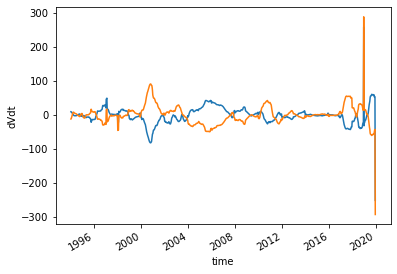

In [57]:
dVdt_anom_bot.plot()
dVdt_anom_deep.plot();

### $\Psi$

In [58]:
psi_anom_deep = anom.psi_vel.sel(sigma2_bin=1037.194, method='nearest') - anom.psi_vel.isel(sigma2_bin=0)
psi_anom_deep.load()

<xarray.DataArray 'psi_vel' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,  9.01566452e-01,
        7.10027165e-01,  7.18059593e-01,  6.98110739e-01,  7.24806203e-01,
        4.50363530e-01,  3.86278047e-01,  1.97180430e-01, -1.87690523e-02,
       -1.21477339e-01, -3.29836580e-01, -5.29395474e-01, -7.27324936e-01,
       -8.18658696e-01, -8.88148838e-01, -1.01793260e+00, -1.13685001e+00,
       -1.30120450e+00, -1.56346411e+00, -1.84931485e+00, -2.23945070e+00,
       -2.81810243e+00, -2.98046627e+00, -3.17198364e+00, -3.20742541e+00,
       -3.32158693e+00, -3.34437162e+00, -3.51231816e+00, -3.72377412e+00,
       -3.76345290e+00, -3.91080170e+00, -4.19165258e+00, -4.44053153e+00,
       -4.69174282e+00, -4.86921790e+00, -5.12114843e+00, -5.24843004e+00,
       -5.41407045e+00, -5.57156965e+00, -5.71827867e+00, -5.96584347e+00,
       -6.17595596e+00, -6.30390384e+00, -6.36121178e+00, -6.51655844e+00,
...
        2.45394770e+00,  2.44489665e+00,  2.43995579e+00,  2.64328628e+00,
        2.73949840e+00,  2.84674994e+00,  2.84041415e+00,  2.85386176e+00,
        2.72801797e+00,  2.61144659e+00,  2.31154723e+00,  2.41470628e+00,
        2.34625742e+00,  2.23899444e+00,  2.24787694e+00,  2.29254394e+00,
        2.29942587e+00,  2.43452371e+00,  2.45139127e+00,  2.30811241e+00,
        2.20273172e+00,  2.01637480e+00,  1.61732944e+00,  1.51555885e+00,
        1.60501756e+00,  1.63726820e+00,  1.68050061e+00,  1.37688907e+00,
        1.34698963e+00,  1.55009905e+00,  1.67837980e+00,  1.55089580e+00,
        1.65861066e+00,  1.74260690e+00,  2.28106668e+00,  2.62000084e+00,
        2.94612291e+00,  3.25052049e+00,  3.45229763e+00,  3.30002361e+00,
        3.31777128e+00,  3.28877767e+00,  3.46391593e+00,  3.64811134e+00,
        3.87159983e+00,  3.94385889e+00,  4.13381131e+00,  4.18132083e+00,
        4.24573856e+00,  4.10805766e+00,  4.17893685e+00,  4.18759410e+00,
        4.20422194e+00,  4.23433219e+00,  4.23747932e+00,  4.43959851e+00,
        4.55950292e+00,  4.74035411e+00,  4.83589766e+00,  4.76847924e+00,
        4.60155318e+00,  4.44629775e+00,  4.34065141e+00,  4.46301927e+00,
        4.24557198e+00,  3.86665810e+00,  3.55112415e+00,  3.58379131e+00,
        3.55799569e+00,  3.43564966e+00,  2.99794324e+00,  2.46609094e+00,
        2.19795757e+00,  1.73445680e+00,  1.34238328e+00,  1.27955225e+00,
        1.12986109e+00])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

In [59]:
psi_anom_bot = anom.psi_vel.isel(sigma2_bin=-1) - anom.psi_vel.sel(sigma2_bin=1037.194, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 985)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,   0.78009947,
         0.7729352 ,   0.64577275,   0.57547053,   0.53728244,
         0.69144622,   0.84526515,   0.8584622 ,   0.91544784,
         0.91132882,   0.97586089,   0.9893114 ,   1.11043111,
         1.16045303,   1.13072149,   1.19515491,   1.21580206,
         1.34463678,   1.64253751,   1.93184521,   2.30684585,
         2.9055522 ,   3.0890024 ,   3.34116597,   3.39109442,
         3.50166622,   3.46366081,   3.61831267,   3.80019698,
         3.85296102,   4.05123161,   4.34612439,   4.64194357,
         4.96472248,   5.27434734,   5.6596856 ,   5.81173731,
         6.00623389,   6.16864717,   6.2919403 ,   6.42633293,
         6.59626667,   6.72512799,   6.91286033,   7.13514994,
...
        -2.23033583,  -2.23372765,  -2.19222099,  -2.36198244,
        -2.27625559,  -2.23371917,  -2.21056163,  -2.12327712,
        -1.99013783,  -1.95894886,  -1.86502396,  -1.94778636,
        -1.93271428,  -1.89702128,  -1.86844857,  -1.82872739,
        -1.88046236,  -2.00933597,  -1.99562912,  -1.85870205,
        -1.80776397,  -1.63435165,  -1.35258465,  -1.37595084,
        -1.78636649,  -2.02089556,  -2.23804424,  -2.12624831,
        -2.32003573,  -2.768137  ,  -3.11333675,  -3.11736075,
        -3.39488335,  -3.57438183,  -4.21801875,  -4.59768581,
        -5.10913754,  -5.61874464,  -6.09513294,  -6.1765958 ,
        -6.29264652,  -6.50897503,  -6.74060939,  -7.05944602,
        -7.29550628,  -7.39014299,  -7.5329661 ,  -7.64040408,
        -7.74969092,  -7.57295769,  -7.74342719,  -7.78556348,
        -7.82356635,  -7.79406517,  -7.86031544,  -8.01890682,
        -8.12776145,  -8.25688217,  -8.36154305,  -8.36220744,
        -8.02018761,  -7.70888204,  -7.47408051,  -7.47572174,
        -7.16255676,  -6.54966371,  -6.07951546,  -6.03268907,
        -5.88954749,  -5.66268042,  -5.14986855,  -4.6064279 ,
        -4.22635265,  -3.65810263,  -3.13332673,  -2.95810454,
        -2.8589737 ])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

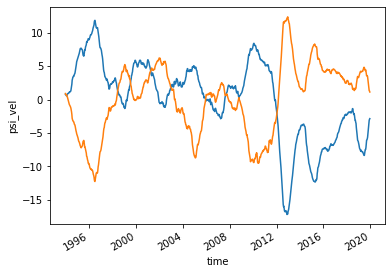

In [60]:
psi_anom_bot.plot()
psi_anom_deep.plot();

### $\Omega$

In [62]:
omega_anom_deep = anom.omega_trans.sel(sigma2_bin=1037.194, method='nearest') - anom.omega_trans.isel(sigma2_bin=0)
omega_anom_deep.load()

<xarray.DataArray 'omega_trans' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -1.20254040e+01, -1.06553716e+01, -8.01000135e+00, -4.56531036e+00,
       -8.40240143e-01,  2.98731283e+00,  6.59881446e+00,  8.56583080e+00,
        8.87440665e+00,  8.21263252e+00,  7.63710207e+00,  7.07117669e+00,
        6.31527074e+00,  6.05799834e+00,  5.73569942e+00,  5.74394945e+00,
        5.66174734e+00,  5.18403926e+00,  4.35535656e+00,  4.08213566e+00,
        3.73404893e+00,  3.16501424e+00,  2.59123630e+00,  1.72395174e+00,
        1.31364677e+00,  5.24798934e-01, -8.63580135e-02, -6.14990714e-01,
        1.46601863e+00,  3.72179534e+00,  5.24431129e+00,  6.59640804e+00,
        6.61908070e+00,  9.51494434e+00,  9.65978619e+00,  9.92315588e+00,
        4.37172402e+00,  3.15563117e+00,  9.29928291e-01,  9.97642538e-01,
       -8.52314642e-01, -2.34145415e+00, -2.24854313e+00, -1.71327678e+00,
...
        4.79196506e+01,  4.94145288e+01,  4.81977528e+01,  4.75582432e+01,
        1.90114335e+01,  1.83230770e+01,  1.86229505e+01,  1.82821124e+01,
        1.88380338e+01,  1.81205610e+01,  1.53037417e+01,  1.30493973e+01,
        9.06604048e+00,  7.92314838e+00,  3.51739441e+00, -2.38316102e+00,
       -4.65908333e+00, -6.53395190e+00, -7.97383828e+00, -3.64391929e+00,
        2.79560497e+00,  8.30429437e+00,  1.21668539e+01,  1.67543463e+01,
        2.69760639e+01,  3.00457594e+01,  3.06079127e+01,  3.14560790e+01,
        3.19730981e+01,  3.22041371e+01,  3.12420435e+01,  3.00356827e+01,
        2.99791645e+01,  2.95960809e+01,  2.76568249e+01,  2.61445895e+01,
        2.19840424e+01,  1.53025223e+01,  1.22391664e+01,  1.07243854e+01,
        2.85692916e+02,  2.17346421e+01,  1.26588187e+01,  1.18378168e+01,
        1.24829634e+01,  1.11025872e+01,  1.08867206e+01,  7.07253393e+00,
        3.91598047e+00, -1.55830912e-02, -2.31114373e+00, -1.13844204e+00,
       -2.43478038e+00, -5.61081213e+00, -9.08718153e+00, -1.79149722e+01,
       -2.76809636e+01, -3.59286457e+01, -4.14013479e+01, -4.66327157e+01,
       -5.73196026e+01, -6.03313524e+01, -6.11616789e+01, -6.23947649e+01,
       -6.32858328e+01, -6.36330970e+01, -6.26298810e+01, -6.12766791e+01,
       -6.07413193e+01, -5.99081824e+01, -5.79214124e+01, -5.94205727e+01,
       -5.77794423e+01, -5.18678876e+01, -4.52142566e+01, -4.31921853e+01,
       -2.93259602e+02])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

In [63]:
omega_anom_bot = anom.omega_trans.isel(sigma2_bin=-1) - anom.omega_trans.sel(sigma2_bin=1037.194, method='nearest')
omega_anom_bot.load()

<xarray.DataArray 'omega_trans' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        9.18494376e+00,  8.87642975e+00,  8.14817927e+00,  7.10238361e+00,
        5.33058607e+00,  3.91533399e+00,  2.49625869e+00,  7.36687371e-01,
       -7.81268931e-01, -1.70974215e+00, -2.51625669e+00, -2.60752096e+00,
       -2.86114102e+00, -2.97987348e+00, -2.95526008e+00, -2.95588837e+00,
       -3.21145680e+00, -3.16086130e+00, -2.80527830e+00, -2.95541759e+00,
       -2.93137378e+00, -2.43140607e+00, -2.05116506e+00, -1.34287566e+00,
       -1.30648036e+00, -8.34257404e-01, -4.72596489e-01, -3.42479191e-01,
       -2.74038335e+00, -5.13587283e+00, -6.54747785e+00, -7.87552345e+00,
       -7.91641383e+00, -3.65174708e+00, -3.48783085e+00, -3.43476694e+00,
       -1.02947410e+01, -1.02807562e+01, -1.04226716e+01, -7.82879847e+00,
       -7.59977024e+00, -8.71690687e+00, -1.03035422e+01, -1.06560364e+01,
...
       -3.74257712e+01, -3.25016610e+01, -3.21596275e+01, -3.22111801e+01,
       -1.62277222e+01, -1.54146096e+01, -1.61421232e+01, -1.64354586e+01,
       -1.68286232e+01, -1.66557565e+01, -1.43038113e+01, -1.24776779e+01,
       -8.30726231e+00, -7.96890048e+00, -3.99998086e+00,  1.45939485e+00,
        4.36100862e+00,  6.40468498e+00,  6.79586915e+00,  1.32211836e+00,
       -5.57629854e+00, -1.12442932e+01, -1.52450571e+01, -2.02949009e+01,
       -2.98855874e+01, -3.43149938e+01, -3.40391396e+01, -3.38370297e+01,
       -3.56727151e+01, -3.66632249e+01, -3.58136761e+01, -3.48638360e+01,
       -3.49898223e+01, -3.50450947e+01, -3.31867867e+01, -3.13530481e+01,
       -2.67551949e+01, -1.97057394e+01, -1.62916819e+01, -1.44886423e+01,
        2.65080884e+02, -2.47625134e+01, -1.53325206e+01, -1.38235596e+01,
       -9.28865344e+00, -7.63934491e+00, -7.03775356e+00, -2.96835256e+00,
        8.62085219e-02,  4.05741964e+00,  6.95545156e+00,  5.92729024e+00,
        7.31979762e+00,  1.02577461e+01,  1.37405243e+01,  2.22489427e+01,
        3.16359212e+01,  3.88915486e+01,  4.39068477e+01,  4.95592180e+01,
        5.95475273e+01,  6.37780902e+01,  6.38881310e+01,  6.41443760e+01,
        6.66541435e+01,  6.78434609e+01,  6.68718462e+01,  6.57405925e+01,
        6.54035380e+01,  6.49935970e+01,  6.32992611e+01,  6.50651781e+01,
        6.33707526e+01,  5.73418321e+01,  5.81441485e+01,  5.64153846e+01,
       -2.47623461e+02])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

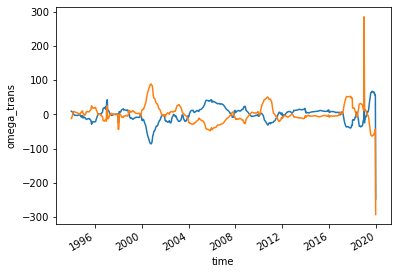

In [64]:
omega_anom_bot.plot()
omega_anom_deep.plot();

In [78]:
omega_anom_bot.time

<xarray.DataArray 'time' (time: 985)>
array(['1993-01-07T01:00:00.000000000', '1993-01-17T01:00:00.000000000',
       '1993-01-27T01:00:00.000000000', ..., '2019-11-27T01:00:00.000000000',
       '2019-12-07T01:00:00.000000000', '2019-12-17T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00

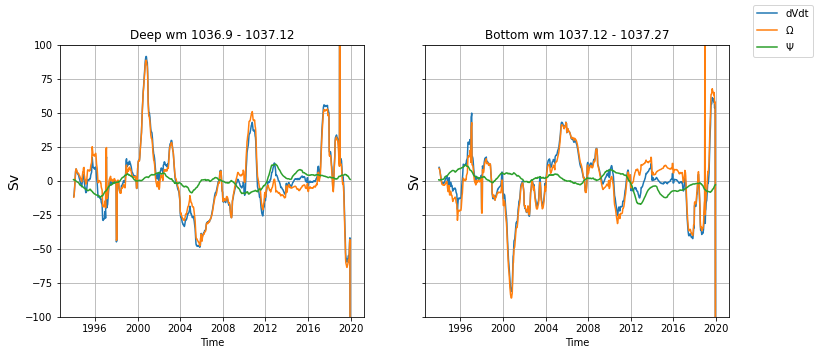

In [82]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5), sharey=True)

ax0.plot(anom.time, dVdt_anom_deep, label='dVdt')
ax0.plot(anom.time, omega_anom_deep, label=r'$\Omega$')
ax0.plot(anom.time, psi_anom_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylim(-100,100)
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('Time')
ax0.grid()

ax1.plot(anom.time, dVdt_anom_bot)#, label='dVdt')
ax1.plot(anom.time, omega_anom_bot)#, label=r'$\Omega$')
ax1.plot(anom.time, psi_anom_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('Time')
ax1.grid()

fig.legend();